In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.__version__

'2.18.0'

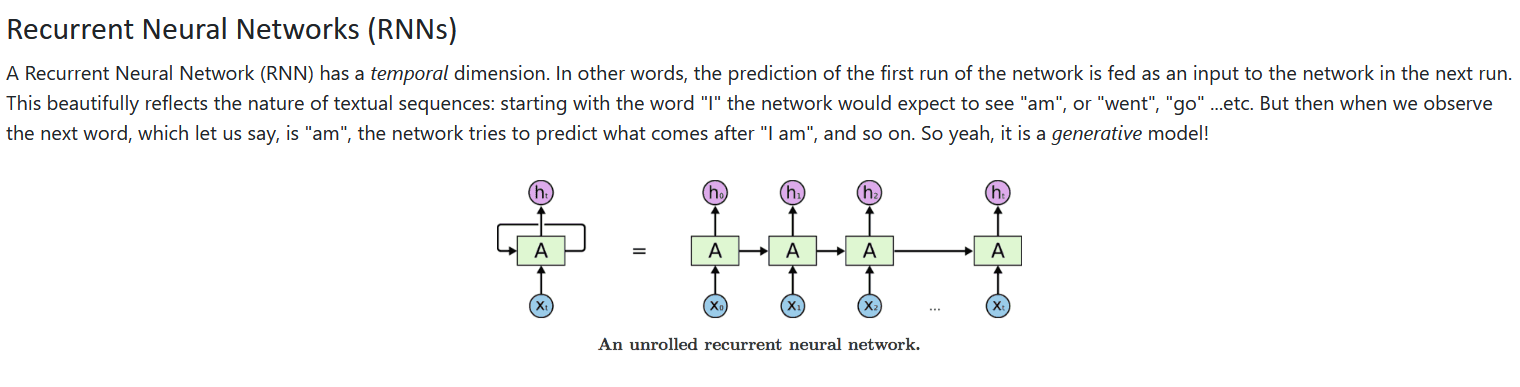

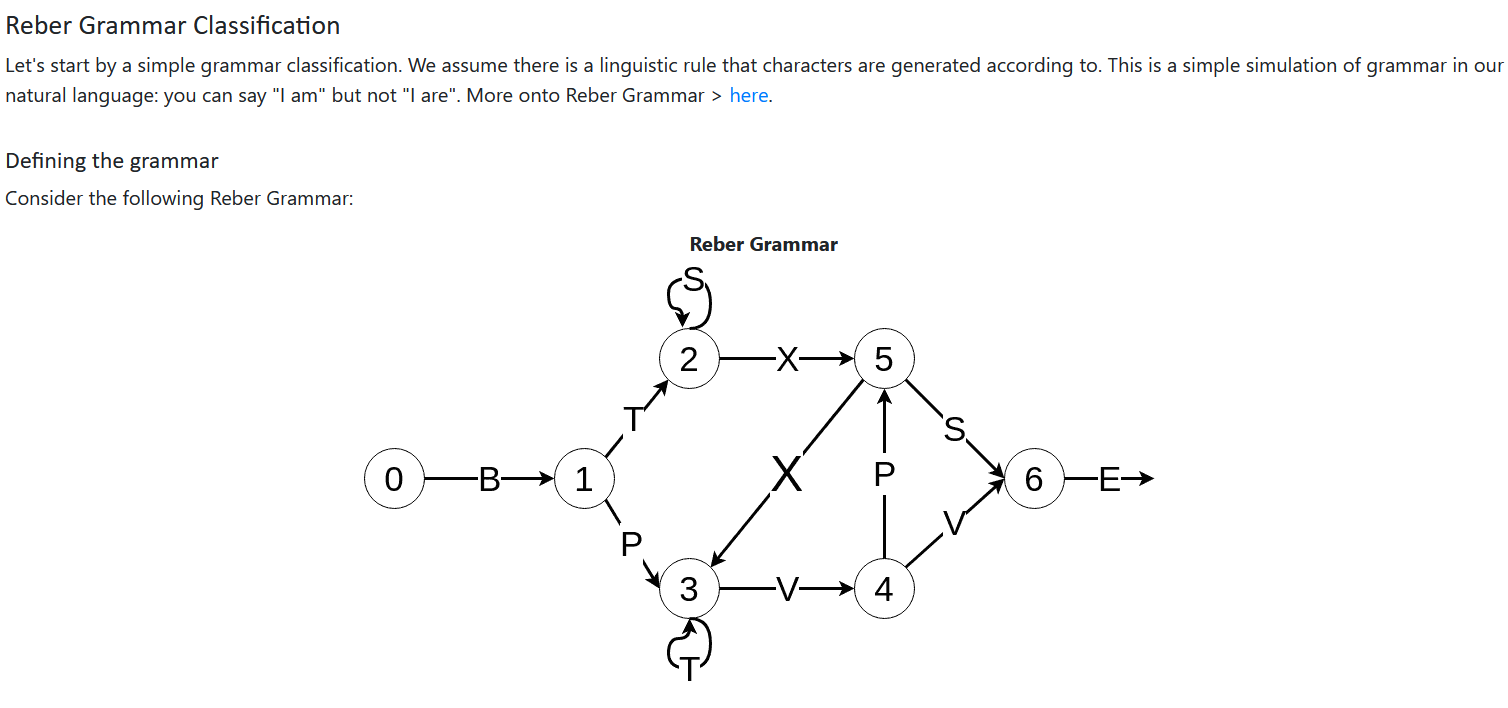]

In [2]:
default_reber_grammar=[
    [("B",1)],  #(state 0) =B=> (state 1)
    [("T", 2),("P", 3)],  # (state 1) =T=> (state 2) or =P=> (state 3)
    [("X", 5), ("S", 2)], # (state 2) =X=> (state 5) or =S=> (state 2)
    [("T", 3), ("V", 4)], # (state 3) =T=> (state 3) or =V=> (state 4)
    [("V", 6), ("P", 5)], # (state 4) =V=> (state 6) or =P=> (state 5)
    [("X",3), ("S", 6)],  # (state 5) =X=> (state 3) or =S=> (state 6)
    [("E", None)]         # (state 6) =E=> <EOS>

    
]
default_reber_grammar


[[('B', 1)],
 [('T', 2), ('P', 3)],
 [('X', 5), ('S', 2)],
 [('T', 3), ('V', 4)],
 [('V', 6), ('P', 5)],
 [('X', 3), ('S', 6)],
 [('E', None)]]

In [3]:
embedded_reber_grammar=[
    [("B",1)],  #(state 0) =B=> (state 1)
    [("T", 2),("P", 3)],  # (state 1) =T=> (state 2) or =P=> (state 3)
    [(default_reber_grammar,4)], # (state 2) =REBER=> (state 4)
    [(default_reber_grammar,5)], # (state 3) =REBER=> (state 5)
    [("P", 6)], # (state 4) =P=> (state 6)
    [("T",6)],  # (state 5) =T=> (state 3)
    [("E", None)]         # (state 6) =E=> <EOS>
    
]

embedded_reber_grammar

[[('B', 1)],
 [('T', 2), ('P', 3)],
 [([[('B', 1)],
    [('T', 2), ('P', 3)],
    [('X', 5), ('S', 2)],
    [('T', 3), ('V', 4)],
    [('V', 6), ('P', 5)],
    [('X', 3), ('S', 6)],
    [('E', None)]],
   4)],
 [([[('B', 1)],
    [('T', 2), ('P', 3)],
    [('X', 5), ('S', 2)],
    [('T', 3), ('V', 4)],
    [('V', 6), ('P', 5)],
    [('X', 3), ('S', 6)],
    [('E', None)]],
   5)],
 [('P', 6)],
 [('T', 6)],
 [('E', None)]]

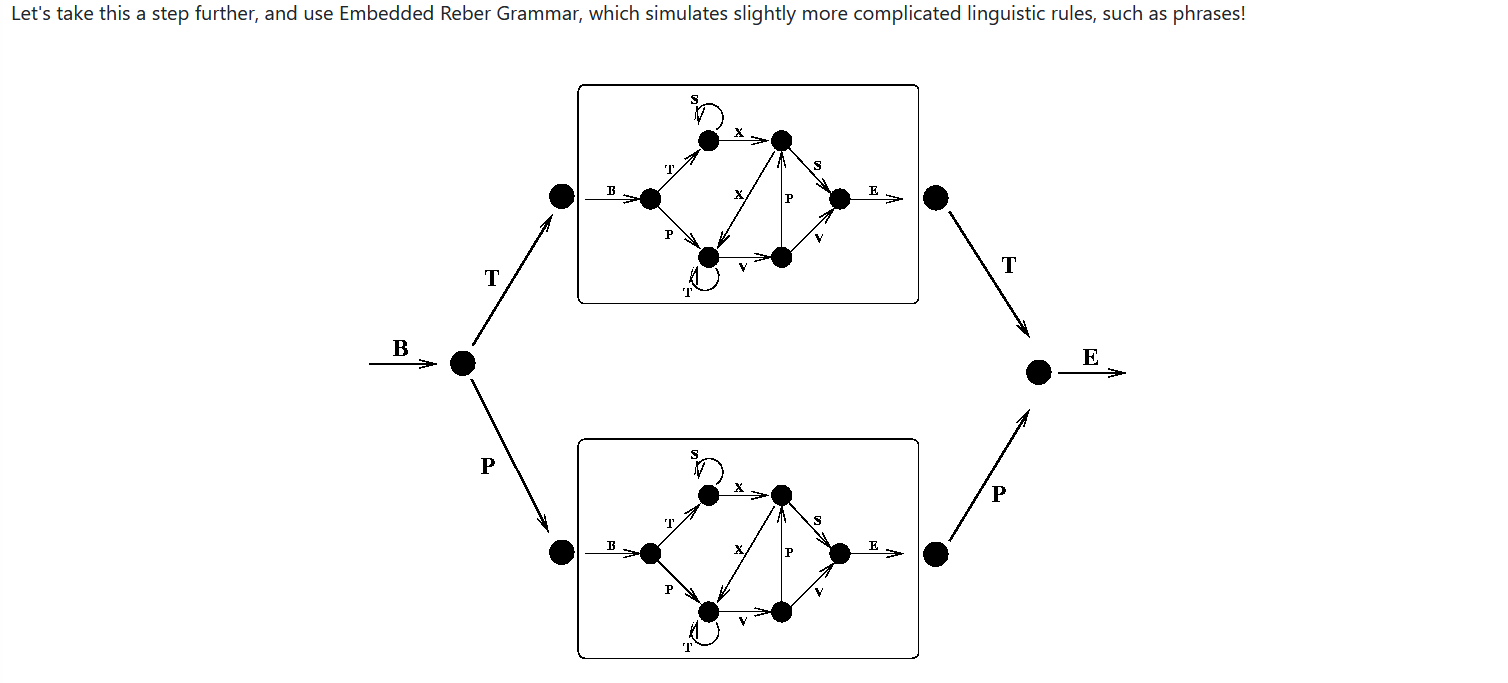

In [4]:
def generate_valid_string(grammar):
    state = 0
    output = []
    while state is not None:
        char, state = grammar[state][np.random.randint(len(grammar[state]))]
        if isinstance(char, list):  # embedded reber
            char = generate_valid_string(char)
        output.append(char)
    return "".join(output)

In [5]:
def generate_corrupted_string(grammar, chars='BTSXPVE'):
    '''Substitute one character to violate the grammar'''
    good_string = generate_valid_string(grammar)
    idx = np.random.randint(len(good_string))
    good_char = good_string[idx]
    bad_char = np.random.choice(sorted(set(chars)-set(good_char)))
    return good_string[:idx]+bad_char+good_string[idx+1:]

In [6]:
chars='BTSXPVE'
chars_dict = {a:i for i,a in enumerate(chars)}
chars_dict

{'B': 0, 'T': 1, 'S': 2, 'X': 3, 'P': 4, 'V': 5, 'E': 6}

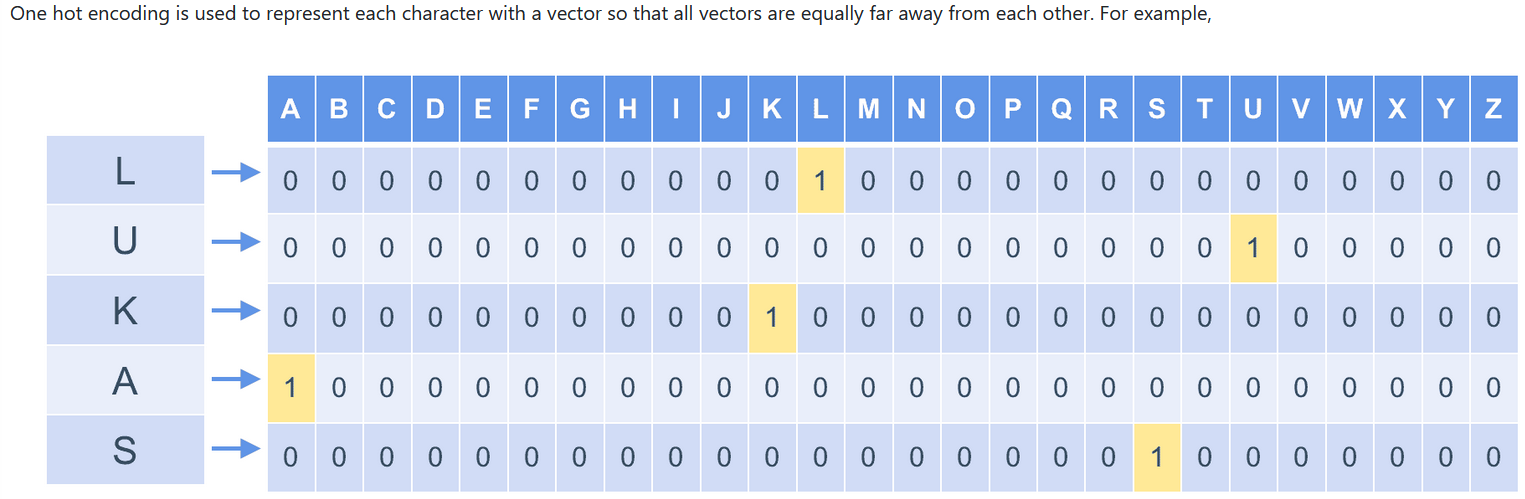

In [7]:
def str2onehot(string, num_steps=12, chars_dict=chars_dict):
    res = np.zeros((num_steps, len(chars_dict)))
    for i in range(min(len(string), num_steps)):
        c = string[i]
        res[i][chars_dict[c]] = 1
    return res

In [8]:
def generate_data(data_size=10000, grammar=embedded_reber_grammar, num_steps=None):
    good = [generate_valid_string(grammar) for _ in range(data_size//2)]
    bad = [generate_corrupted_string(grammar) for _ in range(data_size//2)]
    all_strings = good+bad
    if num_steps is None:
        num_steps = max([len(s) for s in all_strings])
    X = np.array([str2onehot(s) for s in all_strings])
    l = np.array([len(s) for s in all_strings])
    y = np.concatenate((np.ones(len(good)), np.zeros((len(bad))))).reshape(-1, 1)
    idx = np.random.permutation(data_size)
    return X[idx], l[idx], y[idx]

In [9]:
np.random.seed(42)
X_train, seq_lens_train, y_train = generate_data(10000)
X_val, seq_lens_val, y_val = generate_data(5000)
X_train.shape, X_val.shape

((10000, 12, 7), (5000, 12, 7))

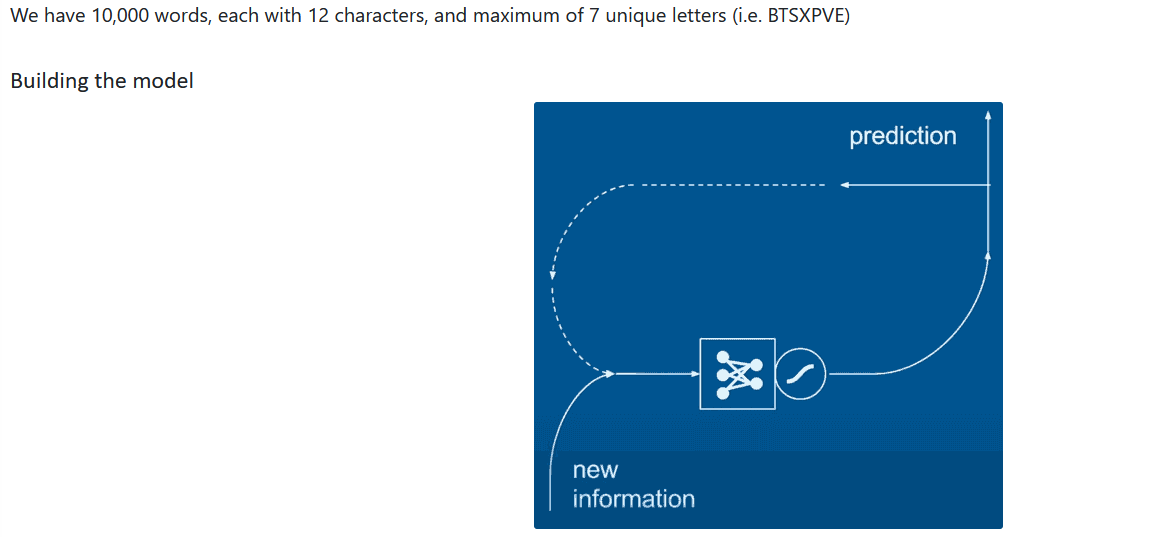

Building Model

In [10]:
x = layers.Input(shape=(12, 7)) # we define our input's shape
# first we define our RNN cells to use in the RNN model
# let's keep the model simple ...
cell = layers.SimpleRNNCell(4, activation='tanh')  # ... by just using 4 units (like 4 units in hidden layers)
rnn = layers.RNN(cell)
rnn_output = rnn(x)

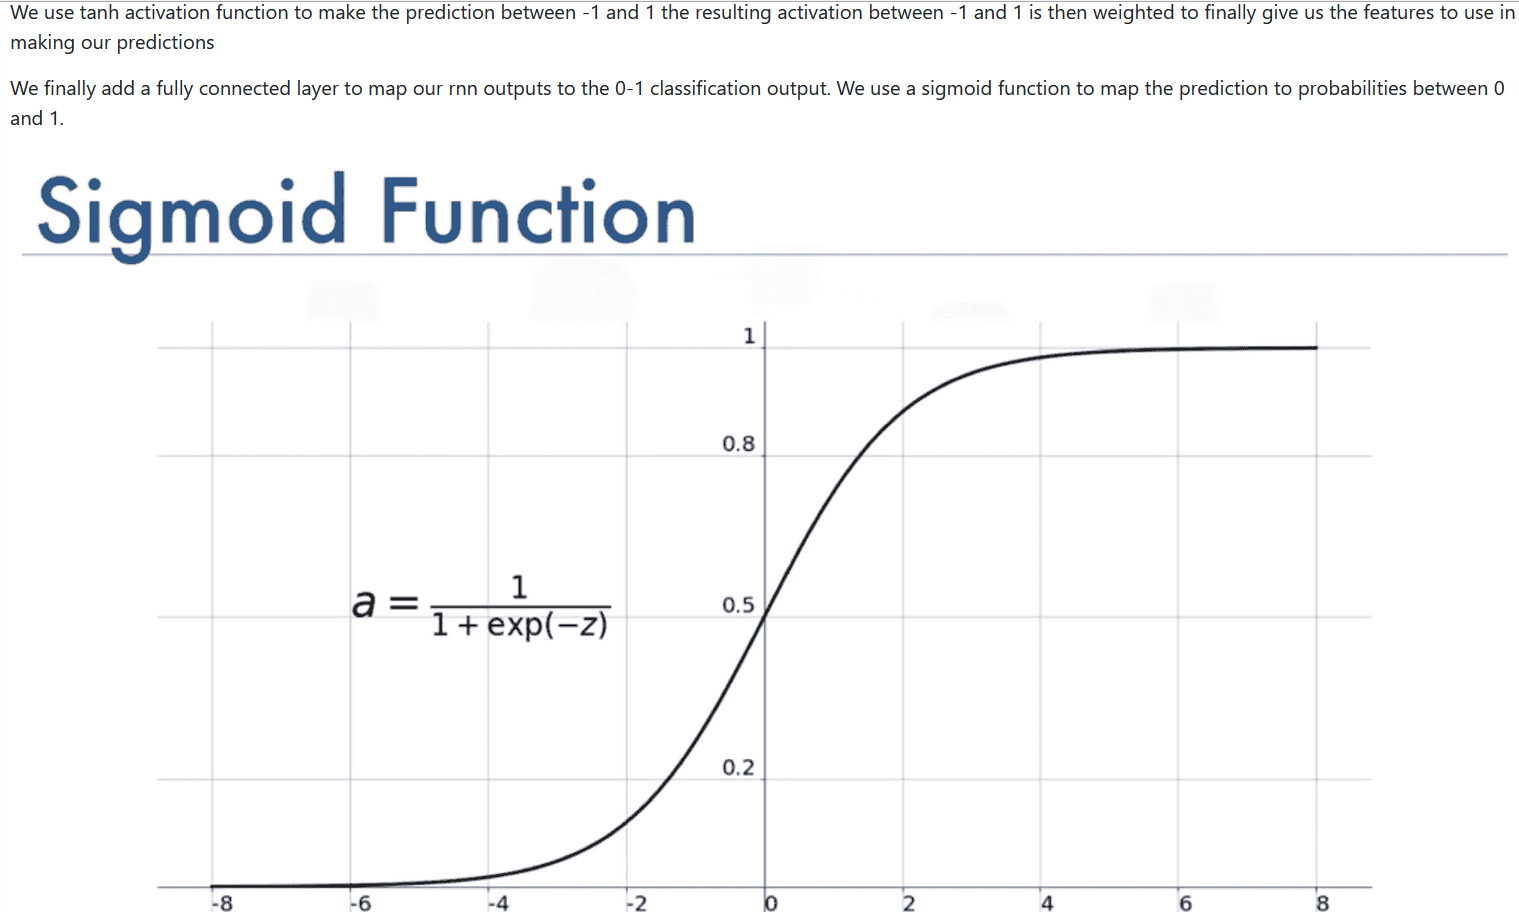

In [11]:
output = layers.Dense(units=1, activation='sigmoid')(rnn_output)

In [12]:
# let's compile the model
model = keras.Model(inputs=x, outputs=output)
# loss is binary cropss entropy since this is a binary classification task
# and evaluation metric as f1
model.compile(loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn (RNN)                       │ (None, 4)              │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53 (212.00 B)

 Trainable params: 53 (212.00 B)

 Non-trainable params: 0 (0.00 B)



We have 12 characters in each input, and 4 units per RNN cell, so we have a total of 12x4=48 parameters to learn + 5 more parameters from the fully connected (FC) layer.


In [13]:
# we train the model for 100 epochs
# verbose level 2 displays more info while trianing
H = model.fit(X_train, y_train, epochs=100, verbose=2, validation_data=(X_val, y_val))

Epoch 1/100
313/313 - 1s - 3ms/step - accuracy: 0.4949 - loss: 0.7354 - val_accuracy: 0.5420 - val_loss: 0.7025
Epoch 2/100
313/313 - 0s - 1ms/step - accuracy: 0.5107 - loss: 0.6976 - val_accuracy: 0.5128 - val_loss: 0.6948
Epoch 3/100
313/313 - 0s - 1ms/step - accuracy: 0.5050 - loss: 0.6941 - val_accuracy: 0.5208 - val_loss: 0.6932
Epoch 4/100
313/313 - 0s - 1ms/step - accuracy: 0.5084 - loss: 0.6931 - val_accuracy: 0.5062 - val_loss: 0.6926
Epoch 5/100
313/313 - 0s - 1ms/step - accuracy: 0.5071 - loss: 0.6926 - val_accuracy: 0.5160 - val_loss: 0.6921
Epoch 6/100
313/313 - 0s - 1ms/step - accuracy: 0.5138 - loss: 0.6921 - val_accuracy: 0.5144 - val_loss: 0.6918
Epoch 7/100
313/313 - 0s - 1ms/step - accuracy: 0.5117 - loss: 0.6917 - val_accuracy: 0.5184 - val_loss: 0.6918
Epoch 8/100
313/313 - 0s - 1ms/step - accuracy: 0.5151 - loss: 0.6915 - val_accuracy: 0.5202 - val_loss: 0.6912
Epoch 9/100
313/313 - 0s - 1ms/step - accuracy: 0.5160 - loss: 0.6909 - val_accuracy: 0.5076 - val_loss:

In [14]:
def plot_results(H):
    results = pd.DataFrame({"Train Loss": H.history['loss'], "Validation Loss": H.history['val_loss'],
              "Train Accuracy": H.history['accuracy'], "Validation Accuracy": H.history['val_accuracy']
             })
    fig, ax = plt.subplots(nrows=2, figsize=(16, 9))
    results[["Train Loss", "Validation Loss"]].plot(ax=ax[0])
    results[["Train Accuracy", "Validation Accuracy"]].plot(ax=ax[1])
    ax[0].set_xlabel("Epoch")
    ax[1].set_xlabel("Epoch")
    plt.show()

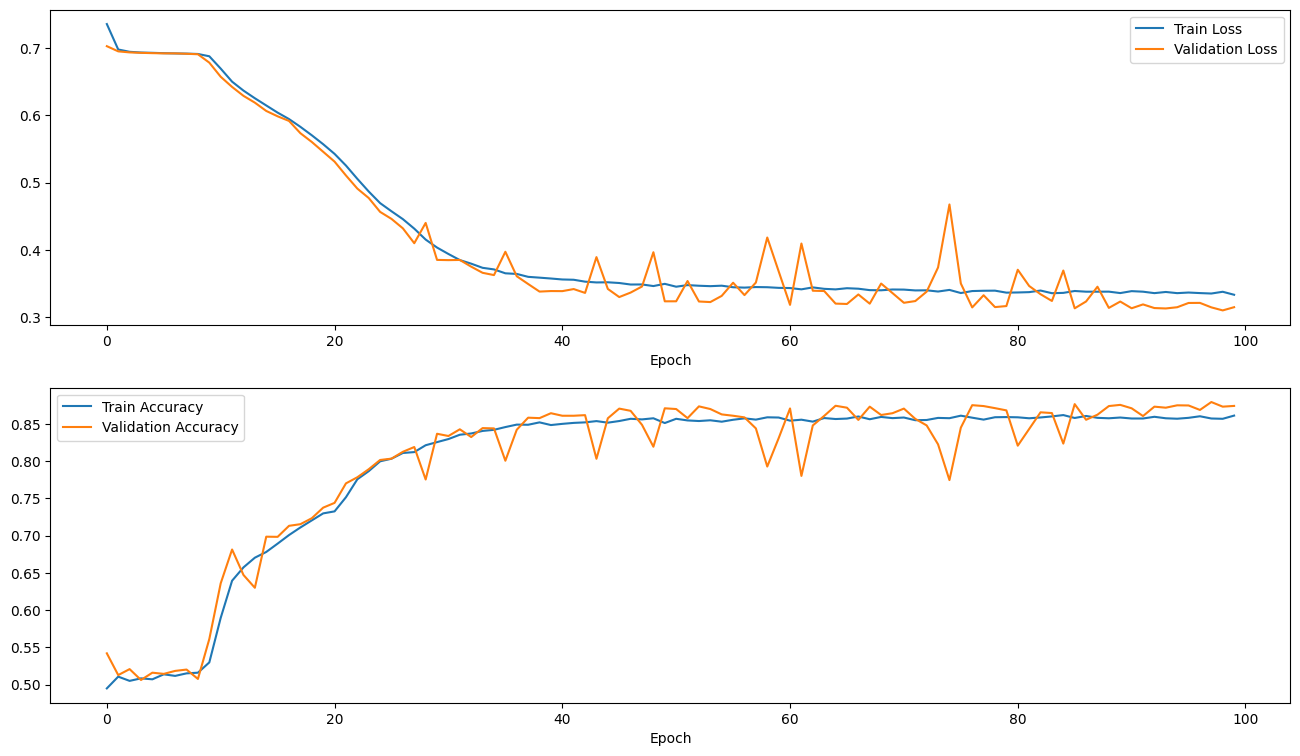

In [15]:
plot_results(H)

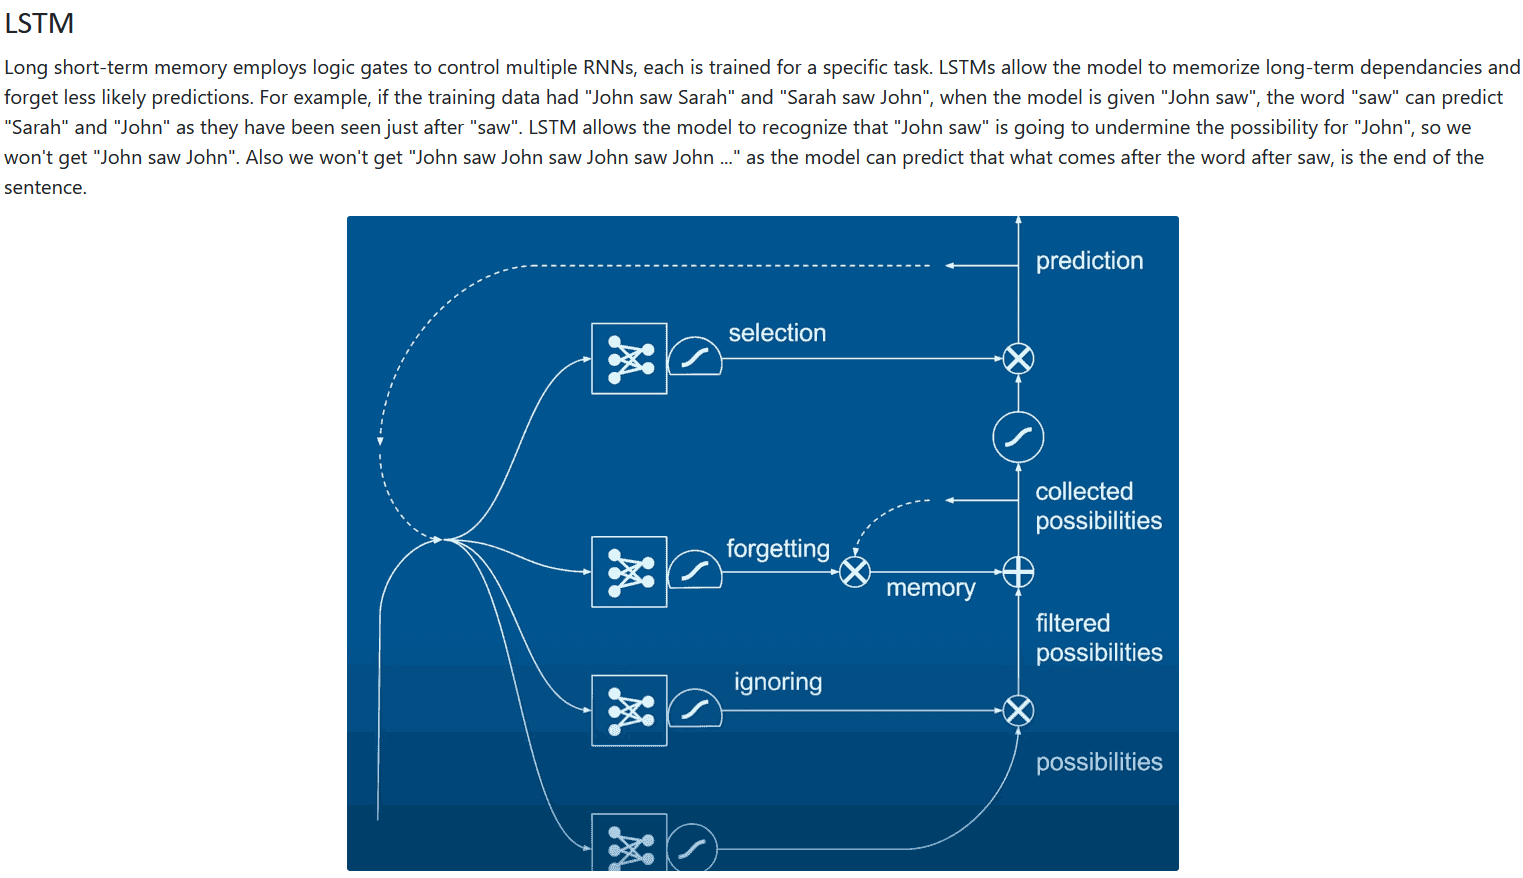

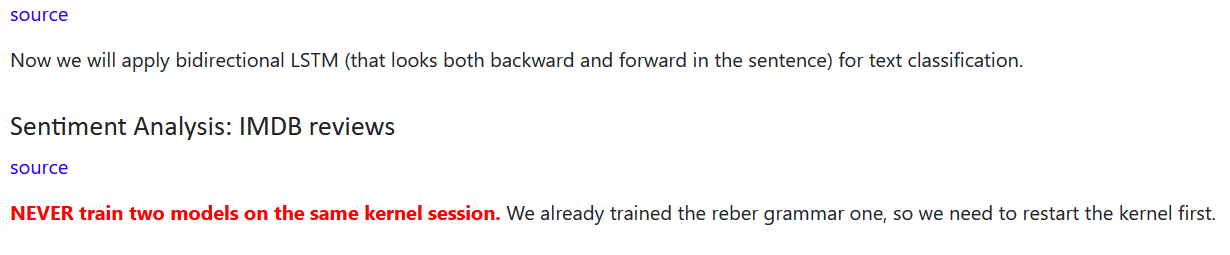

In [16]:
#!pip install -q tensorflow_datasets

In [17]:
import tensorflow_datasets as tfds


Loading the data


In [18]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

c:\Users\gustavo.grillo\Documents\Proyectos\Redneuronal_RNN_LSTM__with_Python\env_tf-matpl-nump-py3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dl Completed...: 100%|██████████| 1/1 [00:00<00:00, 110.92 url/s]
                                                                        

Dataset imdb_reviews downloaded and prepared to C:\Users\gustavo.grillo\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


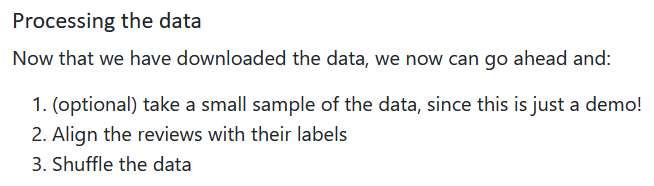

In [19]:
train = train_dataset.take(4000)
test = test_dataset.take(1000)

In [20]:
# to shuffle the data ...
BUFFER_SIZE = 4000 # we will put all the data into this big buffer, and sample randomly from the buffer
BATCH_SIZE = 128  # we will read 128 reviews at a time

train = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test = test.batch(BATCH_SIZE)



prefetch: to allow the later elements to be prepared while the current elements are being processed.


In [21]:
train = train.prefetch(BUFFER_SIZE)
test = test.prefetch(BUFFER_SIZE)


Text Encoding

Each word in the sentence is going to be replaced with its corresponding index in the vocabulary.


In [23]:
VOCAB_SIZE=1000 # assuming our vocabulary is just 1000 words

encoder = layers.TextVectorization(max_tokens=VOCAB_SIZE)

encoder.adapt(train.map(lambda text, label: text)) # we just encode the text, not the labels

In [24]:
# here are the first 20 words in our 1000-word vocabulary
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'i', 'it',
       'this', 'that', 'br', 'was', 'as', 'with', 'for', 'but', 'movie'],
      dtype='<U14')

In [25]:
example, label = list(train.take(1))[0] # that's one batch
len(example)

128

In [26]:
example[0].numpy()

b'While not as bad as it has been made to be (I have seen MUCH worse), this is still a very lame movie. Basically a rehash of Siegel\'s "Coogan\'s Bluff", with the main difference being that Clint Eastwood\'s hat has more charisma than the whole of Joe Don Baker, an unappealing actor if there was one.<br /><br />However, Venantino Venantini is great (and great fun) as the bad guy, sort of a budget Vittorio Gassman. He is the main reason to sit through this steampile, as the rest of the cast deliver mostly terrible acting, specially the girl. Poor old Rossano Brazzi, hard to believe he was once a romantic lead (watch "Mondo Cane" to see him running away from women). Looking here like a second-tier Ben Gazzara, he\'s given next to nothing to do. It\'s all Joe Don\'s show, unfortunately. And all of it scored to generic 80\'s "action movie" music that couldn\'t be more boring.<br /><br />Greydon Clark can make good B-Movies ("Without Warning"), but here he trips, falls, breaks his nose and

In [27]:
encoded_example = encoder(example[:1]).numpy()
encoded_example

array([[129,  22,  15,  88,  15,  10,  46,  78,  94,   6,  28,   9,  26,
        111,  72, 455,  11,   7, 122,   4,  52, 766,  19, 608,   4,   1,
          5,   1,   1,   1,  16,   2, 290,   1, 110,  12,   1,   1,   1,
         46,  51,   1,  71,   2, 219,   5, 951,   1,   1,  35,   1, 261,
         43,  49,  14,   1,  13, 192,   1,   1,   7,  80,   3,  80, 242,
         15,   2,  88, 231, 435,   5,   4, 458,   1,   1,  27,   7,   2,
        290, 288,   6, 842, 135,  11,   1,  15,   2, 357,   5,   2, 185,
          1, 662, 387, 112,   1,   2, 241, 337, 166,   1,   1, 254,   6,
        245,  27,  14, 277,   4, 780, 480, 104,   1,   1,   6,  67,  90,
        615, 247,  38, 386, 289, 138,  39,   4,   1, 973,   1, 226, 320,
        378,   6, 162,   6,  82,  30,  32, 951,   1, 120, 469,   3,  32,
          5,  10,   1,   6,   1, 959, 223,  19, 215,  12, 346,  28,  51,
          1,  13,   1,   1,  69,  98,  50,   1, 204,   1,  18, 138,  27,
          1, 646,   1,  23,   1,   3,   1, 271,   1

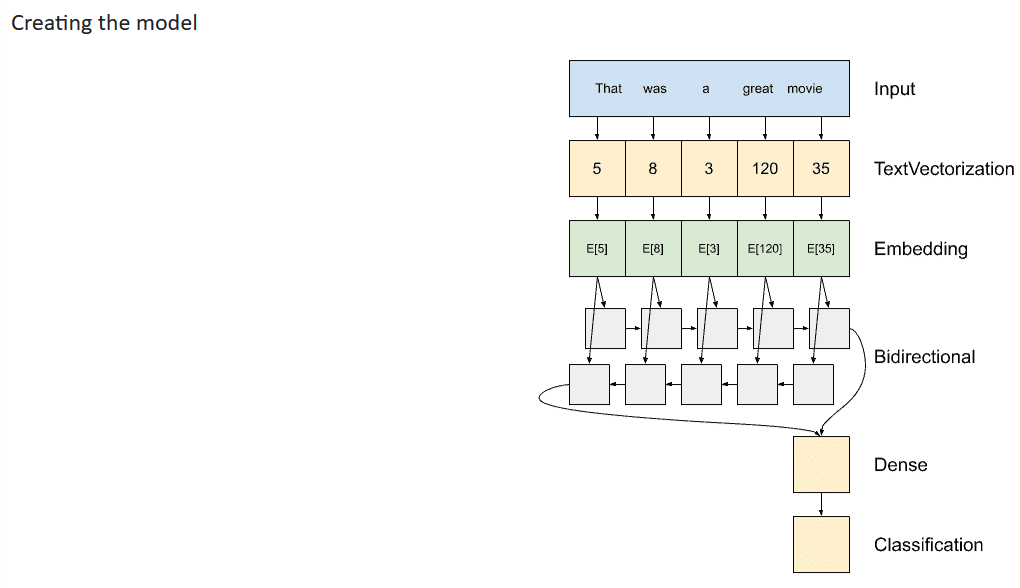

In [28]:
model = tf.keras.Sequential([
    encoder, # the encoder
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(layers.LSTM(64)), # making LSTM bidirectional
    tf.keras.layers.Dense(32, activation='relu'), # FC layer for the classification part
    tf.keras.layers.Dense(1) # final FC layer

])

In [31]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
               
# Primero codificar el texto
encoded_text = encoder([sample_text])
# Luego hacer la predicción
predictions = model.predict(encoded_text)
print(predictions[0])

ValueError: Exception encountered when calling TextVectorization.call().

[1mWhen using `TextVectorization` to tokenize strings, the input rank must be 1 or the last shape dimension must be 1. Received: inputs.shape=(1, 19) with rank=2[0m

Arguments received by TextVectorization.call():
  • inputs=tf.Tensor(shape=(1, 19), dtype=string)